In [1]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 51.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=d2e5f54f27d2ac741de5139320ebb52a2a6c369dd7ef7f2444d487a394bcc801
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from typing import Dict, List, Optional, Sequence, Tuple
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi

from IPython import display
from matplotlib import pyplot as plt
import seaborn as sns

2025-05-03 18:39:11.026636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746297551.508111      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746297551.645859      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

_SAMPLING_RATE = 16000

In [4]:
import pathlib
import glob

data_dir = pathlib.Path('/kaggle/input/maestro-v1-0-0-midi')

filenames = glob.glob(str(data_dir / '**/*.mid*'), recursive=True)

print('Number of files:', len(filenames))


Number of files: 1184


In [5]:
# analyzing and working with a sample file

sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

# Extracting the notes
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}')

/kaggle/input/maestro-v1-0-0-midi/maestro-v1.0.0/2017/MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--4.midi
Number of instruments: 1
Instrument name: Acoustic Grand Piano
0: pitch=39, note_name=D#2, duration=0.1323
1: pitch=51, note_name=D#3, duration=0.0438
2: pitch=51, note_name=D#3, duration=0.0354
3: pitch=51, note_name=D#3, duration=0.0417
4: pitch=58, note_name=A#3, duration=0.5167
5: pitch=63, note_name=D#4, duration=0.5417
6: pitch=51, note_name=D#3, duration=0.0427
7: pitch=51, note_name=D#3, duration=0.0385
8: pitch=51, note_name=D#3, duration=0.0396
9: pitch=67, note_name=G4, duration=0.9250


In [6]:
# Extracting the notes from the sample MIDI file

def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,67,0.988542,1.913542,0.000000,0.925000
1,63,0.997917,1.539583,0.009375,0.541667
2,39,1.003125,1.135417,0.005208,0.132292
3,58,1.012500,1.529167,0.009375,0.516667
4,51,1.150000,1.193750,0.137500,0.043750


In [7]:
# Converting to note names by considering the respective pitch values

get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
print(sample_note_names[:10])

# Visualizing the paramaters of the muscial notes of the piano

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
        
        plt.figure(figsize=(20, 4))
        plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
        plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
        
        plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        _ = plt.title(title)

['G4' 'D#4' 'D#2' 'A#3' 'D#3' 'D#3' 'D#3' 'D#3' 'D#3' 'D#4']


In [8]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        
        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']),
                                start=start, end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [9]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

Number of notes parsed: 21238


I0000 00:00:1746297577.381797      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746297577.382693      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [10]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int,
                     vocab_size = 128) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)
    
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

In [11]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [12]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [13]:
# Developing the model

input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = Input(input_shape)
x = LSTM(128)(inputs)

outputs = {'pitch': Dense(128, name='pitch')(x),
           'step': Dense(1, name='step')(x),
           'duration': Dense(1, name='duration')(x),
          }

model = Model(inputs, outputs)

loss = {'pitch': SparseCategoricalCrossentropy(from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
       }

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │         67,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]


In [15]:
# Compiling and fitting the model

model.compile(loss = loss, 
              loss_weights = {'pitch': 0.05, 'step': 1.0, 'duration':1.0,},
              optimizer = optimizer)

epochs = 50

history = model.fit(train_ds, 
                    epochs=epochs, 
                    callbacks=callbacks,)

Epoch 1/50


I0000 00:00:1746297585.898008      73 cuda_dnn.cc:529] Loaded cuDNN version 90300


331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - duration_loss: 0.0698 - loss: 0.3215 - pitch_loss: 0.2124 - step_loss: 0.0393
Epoch 2/50
 25/331 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - duration_loss: 0.0728 - loss: 0.2843 - pitch_loss: 0.1955 - step_loss: 0.0160

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - duration_loss: 0.0630 - loss: 0.2822 - pitch_loss: 0.1962 - step_loss: 0.0230
Epoch 3/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - duration_loss: 0.0625 - loss: 0.2796 - pitch_loss: 0.1945 - step_loss: 0.0226
Epoch 4/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - duration_loss: 0.0620 - loss: 0.2751 - pitch_loss: 0.1910 - step_loss: 0.0221
Epoch 5/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - duration_loss: 0.0612 - loss: 0.2716 - pitch_loss: 0.1885 - step_loss: 0.0218
Epoch 6/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - duration_loss: 0.0601 - loss: 0.2687 - pitch_loss: 0.1871 - step_loss: 0.0215
Epoch 7/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - duration_loss: 0.0593 - loss: 0.2668 - pitch_loss: 0.1862 - step_loss: 0.0213
Epoch 8/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - duration_loss: 0.0580 - loss: 0.2646 - pitch_loss: 0.1859 - step_loss: 0.0207
Epoch 9/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - duration_loss: 0.0577 - loss: 0.2

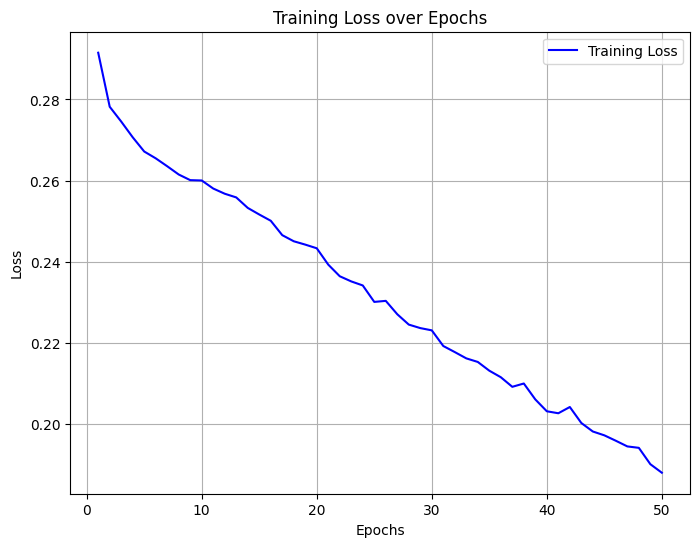

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
print(history.history.keys())

dict_keys(['duration_loss', 'loss', 'pitch_loss', 'step_loss'])


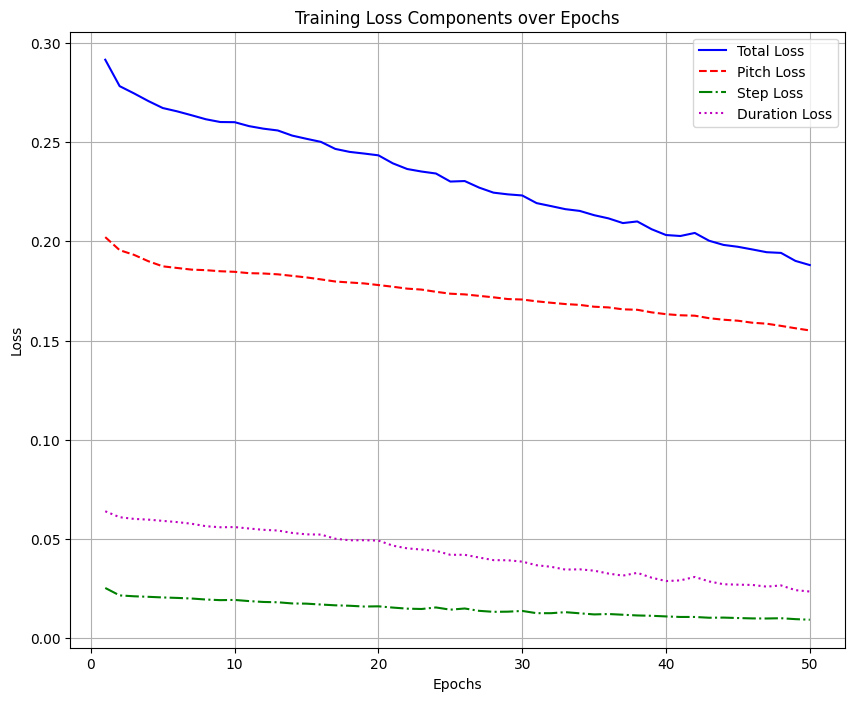

In [18]:
import matplotlib.pyplot as plt

history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 8))

plt.plot(epochs, history_dict['loss'], 'b-', label='Total Loss')
plt.plot(epochs, history_dict['pitch_loss'], 'r--', label='Pitch Loss')
plt.plot(epochs, history_dict['step_loss'], 'g-.', label='Step Loss')
plt.plot(epochs, history_dict['duration_loss'], 'm:', label='Duration Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Components over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model, 
                      temperature: float = 1.0) -> int:
    """Generates a note ID using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = keras_model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    # Debugging: print the raw outputs
    print(f"Predictions - Pitch logits: {pitch_logits}, Step: {step}, Duration: {duration}")

    # Apply temperature scaling to pitch logits
    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)

    # Apply temperature scaling to step and duration
    step /= temperature
    duration /= temperature

    # Ensure step and duration are non-negative
    step = tf.maximum(0.1, step)  # Minimum value of 0.1 to avoid zero
    duration = tf.maximum(0.1, duration)  # Minimum value of 0.1 to avoid zero

    # Debugging: print final values for step and duration
    print(f"Adjusted - Pitch: {pitch}, Step: {step}, Duration: {duration}")

    return int(pitch), float(step), float(duration)


In [20]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes while the pitch is normalized similar to training sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0

# Slowing down factor (adjust this to change the speed)
slowdown_factor = 2.0  # Increase this value to slow down the music

for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)

    # Apply the slowdown factor to step and duration
    step *= slowdown_factor
    duration *= slowdown_factor

    start = prev_start + step
    end = start + duration

    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start
generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

generated_notes.head(10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predictions - Pitch logits: [[-12.577352   -12.263617   -12.438593   -12.404461   -12.252219
  -12.509274   -12.411448   -12.524654   -12.340958   -12.285791
  -12.558363   -12.19107    -12.326184   -12.369116   -12.470906
  -12.570421   -12.430332   -12.533898   -12.367392   -12.455293
  -12.359925   -12.280619   -12.385658   -12.296414   -12.45091
  -12.287602    -7.4073563  -12.303754    -8.410564    -5.200753
   -3.1681857   -3.2120433   -3.0550222   -1.6168354   -2.6060133
   -1.463143    -1.2641904   -6.0217648   -1.4338789   -0.19868784
   -0.36896285   1.0251455   -0.90129673   1.6702404    3.9048924
    2.4532228    3.1097414    1.6307924    4.9335685    5.2257414
    5.0056286    8.991011     2.9031239    4.9364166    2.291706
    3.8471916    3.7028453    4.8253493    4.059177     2.1143777
    2.40916      0.6462346    2.8299463    2.7125506   -1.8199615
    1.2827263   -1.4384172    0.34380743   1.2614398   -0.8105453
    0.62945235  

,pitch,step,duration,start,end
0,44,0.2,0.246354,0.2,0.446354
1,79,0.2,0.200000,0.4,0.600000
2,79,0.2,0.200000,0.6,0.800000
3,84,0.2,0.200000,0.8,1.000000
4,80,0.2,0.200000,1.0,1.200000
5,76,0.2,0.200000,1.2,1.400000
6,86,0.2,0.200000,1.4,1.600000
7,96,0.2,0.200000,1.6,1.800000
8,84,0.2,0.200000,1.8,2.000000
9,84,0.2,0.200000,2.0,2.200000


In [21]:
out_file = 'output.midi'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)

In [22]:
from IPython.display import FileLink

FileLink(out_file)

/kaggle/working/output.midi

In [23]:
model.save('my_model.keras')

In [24]:
from keras.models import load_model

# First, define or import your custom function again
def mse_with_positive_pressure(y_true, y_pred):
    # Make sure this matches EXACTLY what you used in training
    # Example:
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Then load the model, passing the function in custom_objects
model = load_model('my_model.keras', custom_objects={'mse_with_positive_pressure': mse_with_positive_pressure})

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │         67,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 253,064 (988.54 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 168,710 (659.03 KB)

In [26]:
!pip install pygmo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 19.8 MB/s eta 0:00:00


In [27]:
import tensorflow as tf
import pygmo as pg
import numpy as np
from IPython.display import clear_output, display
import time

seq_length = 25
num_features = 3  

In [28]:
def create_dummy_dataset():
    X = np.random.rand(1000, seq_length, num_features)
    y_pitch = np.random.randint(0, 128, size=(1000,))
    y_step = np.random.rand(1000,)
    y_duration = np.random.rand(1000,)
    dataset = tf.data.Dataset.from_tensor_slices((X, {'pitch': y_pitch, 'step': y_step, 'duration': y_duration}))
    dataset = dataset.batch(32)
    return dataset

train_ds = create_dummy_dataset()

In [29]:
def build_model(lstm_units, learning_rate):
    inputs = tf.keras.layers.Input(shape=(seq_length, num_features))
    x = tf.keras.layers.LSTM(lstm_units)(inputs)
    
    pitch_output = tf.keras.layers.Dense(128, activation='softmax', name='pitch')(x)
    step_output = tf.keras.layers.Dense(1, activation='linear', name='step')(x)
    duration_output = tf.keras.layers.Dense(1, activation='linear', name='duration')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs={'pitch': pitch_output, 'step': step_output, 'duration': duration_output})

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss={'pitch': 'sparse_categorical_crossentropy', 'step': 'mse', 'duration': 'mse'}
    )
    return model

In [30]:
def fitness_function(hyperparameters):
    lstm_units = int(hyperparameters[0])
    learning_rate = hyperparameters[1]
    batch_size = int(hyperparameters[2])

    model = build_model(lstm_units, learning_rate)

    train_ds_repeated = train_ds.repeat()
    steps_per_epoch = 10  # adjust based on your data

    history = model.fit(
        train_ds_repeated,
        epochs=2,  # keep small for faster search
        steps_per_epoch=steps_per_epoch,
        batch_size=batch_size,
        verbose=0
    )
    
    pitch_loss = history.history['pitch_loss'][-1]
    step_loss = history.history['step_loss'][-1]
    duration_loss = history.history['duration_loss'][-1]
    total_loss = pitch_loss + step_loss + duration_loss

    return total_loss

In [31]:
class LSTM_Hyperparameter_Optimization:
    def __init__(self, fitness_function):
        self.fitness_function = fitness_function

    def fitness(self, x):
        return [self.fitness_function(x)]

    def get_bounds(self):
        return ([50, 0.0001, 32], [200, 0.01, 256])  # [min], [max] for LSTM units, learning rate, batch size

In [32]:
problem = pg.problem(LSTM_Hyperparameter_Optimization(fitness_function))
algo = pg.algorithm(pg.gwo(gen=20))  # Grey Wolf Optimizer, 20 generations
pop = pg.population(problem, size=5)  # 5 solutions (wolves)

In [33]:
def dynamic_progress(pop, generation):
    best_solution = pop.champion_x
    best_fitness = pop.champion_f
    clear_output(wait=True)
    display(f"Generation {generation}: Best LSTM Units: {int(best_solution[0])}, "
            f"Learning Rate: {best_solution[1]:.6f}, "
            f"Batch Size: {int(best_solution[2])}, "
            f"Fitness (loss): {best_fitness[0]:.4f}")
    time.sleep(0.1)


In [34]:
for generation in range(1, 21):
    pop = algo.evolve(pop)
    dynamic_progress(pop, generation)

best_solution = pop.champion_x
best_fitness = pop.champion_f

print(f"Best hyperparameters after optimization:")
print(f"LSTM Units: {int(best_solution[0])}")
print(f"Learning Rate: {best_solution[1]:.6f}")
print(f"Batch Size: {int(best_solution[2])}")
print(f"Best combined loss (fitness): {best_fitness[0]:.4f}")


'Generation 20: Best LSTM Units: 140, Learning Rate: 0.003227, Batch Size: 256, Fitness (loss): 5.0096'

Best hyperparameters after optimization:
LSTM Units: 140
Learning Rate: 0.003227
Batch Size: 256
Best combined loss (fitness): 5.0096


In [35]:
#Generation 1: Best LSTM Units: 50, Learning Rate: 0.004885, Batch Size: 150, Fitness (loss): 5.0374'
#Generation 2: Best LSTM Units: 58, Learning Rate: 0.002938, Batch Size: 33, Fitness (loss): 5.0331
#Generation 3: Best LSTM Units: 58, Learning Rate: 0.002938, Batch Size: 33, Fitness (loss): 5.0331'
#Generation 4: Best LSTM Units: 58, Learning Rate: 0.002938, Batch Size: 33, Fitness (loss): 5.0331
#Generation 5: Best LSTM Units: 58, Learning Rate: 0.002938, Batch Size: 33, Fitness (loss): 5.0331
#Generation 6: Best LSTM Units: 58, Learning Rate: 0.002938, Batch Size: 33, Fitness (loss): 5.0331
#Generation 7: Best LSTM Units: 100, Learning Rate: 0.001804, Batch Size: 94, Fitness (loss): 5.0326
#Generation 8: Best LSTM Units: 100, Learning Rate: 0.001804, Batch Size: 94, Fitness (loss): 5.0326
#'Generation 9: Best LSTM Units: 100, Learning Rate: 0.001804, Batch Size: 94, Fitness (loss): 5.0326
#Generation 10: Best LSTM Units: 100, Learning Rate: 0.001804, Batch Size: 94, Fitness (loss): 5.0326'
#Generation 11: Best LSTM Units: 100, Learning Rate: 0.001804, Batch Size: 94, Fitness (loss): 5.0326
#Generation 12: Best LSTM Units: 100, Learning Rate: 0.001804, Batch Size: 94, Fitness (loss): 5.0326
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#